Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 506ms/step - loss: 0.3032 - val_loss: 0.3108
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2767 - val_loss: 0.2889
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2665 - val_loss: 0.2627
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2395 - val_loss: 0.2276
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2113 - val_loss: 0.1773
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1705 - val_loss: 0.1085
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1192 - val_loss: 0.0357
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0807 - val_loss: 0.0317
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0927 - val_loss: 0.0309
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0727 - val_loss: 0.0376
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0686 - val_loss: 0.0482
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0766 - val_loss: 0.0524
Epoch 13/5

<ipython-input-7-b1b5c904a121>:75: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates_future = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=num_months_to_predict, freq='M')


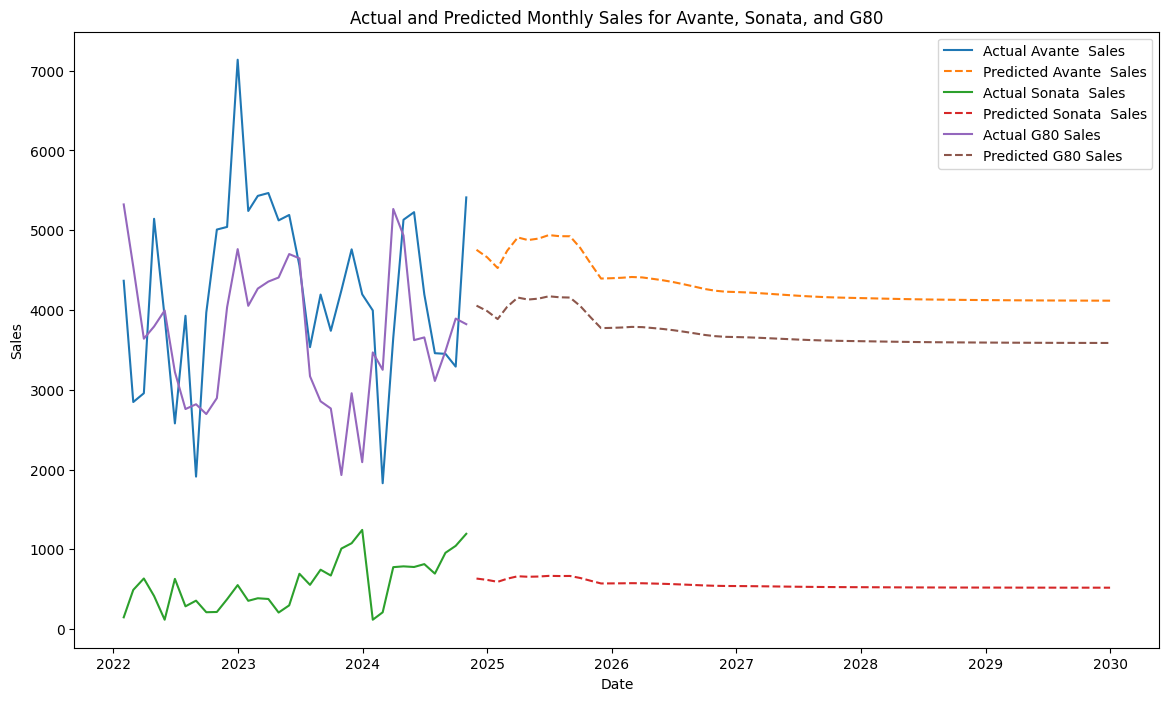

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Step 1: Load the data
# Upload your Excel file to Google Colab and set the file path accordingly
file_path = 'month_updated_transposed_cleaned.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Step 2: Data Preparation
# Convert the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the Date column as the index
df.set_index('Date', inplace=True)

# We will use MinMaxScaler to normalize the sales data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data for each model
scaled_data = scaler.fit_transform(df)

# Create function to prepare the dataset for LSTM
def prepare_data(series, look_back=12):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:i + look_back])
        y.append(series[i + look_back])
    return np.array(X), np.array(y)

# Set look_back period to 12 months for seasonal pattern
look_back = 12
X, y = prepare_data(scaled_data, look_back)

# Split the data into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the input data to be 3D [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model.add(LSTM(100, activation='relu'))  # Another LSTM layer without returning sequences
model.add(Dense(X_train.shape[2]))  # Dense layer with number of features as output
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Step 4: Predict the future sales for each model up to 2030
# We will predict monthly sales for the period until December 2030
num_months_to_predict = 12 * (2029 - 2024) + (12 - 10)

# Use the last available data to start predictions
predictions = []
last_data = scaled_data[-look_back:]

for _ in range(num_months_to_predict):
    last_data_reshaped = last_data.reshape((1, look_back, X_train.shape[2]))
    pred = model.predict(last_data_reshaped)
    predictions.append(pred[0])
    last_data = np.append(last_data[1:], pred, axis=0)

# Inverse transform the predictions to get original scale
predicted_sales = scaler.inverse_transform(predictions)

# Step 5: Plot the predictions for each model
dates_future = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=num_months_to_predict, freq='M')

# Create a dataframe for the predictions
predicted_df = pd.DataFrame(predicted_sales, columns=df.columns, index=dates_future)

# Print predictions for November, December 2024 and the entire 2025
dates_2024_2025 = predicted_df.loc['2024-11-01':'2029-12-31']
print("Predictions for November, December 2024 and 2029:")
print(dates_2024_2025)


# Save predictions for November, December 2024 and 2025 to a log file
with open('predictions_2024_2025_log.txt', 'w') as log_file_2024_2025:
    log_file_2024_2025.write("Predictions for November, December 2024 and 2029:\n")
    log_file_2024_2025.write(dates_2024_2025.to_string())

# Print predictions up to 2030 and save them to a log file
print("Predictions up to 2030:")
print(predicted_df)

# Save predictions to a log file
with open('predictions_log.txt', 'w') as log_file:
    log_file.write("Predictions up to 2030:\n")
    log_file.write(predicted_df.to_string())

# Plot the predictions for each car model
plt.figure(figsize=(14, 8))

for column in df.columns:
    plt.plot(df.index, df[column], label=f'Actual {column} Sales')
    plt.plot(predicted_df.index, predicted_df[column], linestyle='--', label=f'Predicted {column} Sales')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual and Predicted Monthly Sales for Avante, Sonata, and G80')
plt.legend()
plt.show()